# Simple production forecast without making use of weather data

In [1]:
#import packages & libraries
from prophet import Prophet
import pandas as pd
%matplotlib inline
import plotly.express as px

In [2]:
#initialize plotly
import plotly.io as pio

pio.renderers.default = 'colab'

## Exploratory Data Analysis

In [3]:
#read dataset
df = pd.read_csv('./../datasets/prod-region.csv', sep=';')
df.head(1000)

D:\anaconda3\envs\v-env\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning:

Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.



,Horodate,Région,Code région,Plage de puissance injection,Filière de production,Nb points injection,Total énergie injectée (Wh),Courbe Moyenne n°1 (Wh),Indice représentativité Courbe n°1 (%),Courbe Moyenne n°2 (Wh),Indice représentativité Courbe n°2 (%),Courbe Moyenne n°1 + n°2 (Wh),Indice représentativité Courbe n°1 + n°2 (%),Jour max du mois (0/1),Semaine max du mois (0/1)
0,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P3 : ]9 - 100] kW,F5 : Solaire,6625,0.0,NaN,S,NaN,S,NaN,S,S,S
1,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P6 : ]1000 - 12000] kW,F5 : Solaire,272,0.0,0.0,49,0.0,50,0.0,99,0,0
2,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P2 : ]3 - 9] kW,F5 : Solaire,18491,0.0,NaN,S,NaN,S,NaN,S,S,S
3,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P4 : ]100 - 250] kW,F5 : Solaire,1379,0.0,0.0,49,0.0,50,0.0,100,0,0
4,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P7 : > 12000 kW,F5 : Solaire,14,0.0,0.0,50,0.0,50,0.0,100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P3 : ]9 - 100] kW,F5 : Solaire,6608,7712994.0,NaN,S,NaN,S,NaN,S,S,S
996,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P1 : ]0 - 3] kW,F5 : Solaire,42924,1273208.0,NaN,S,NaN,S,NaN,S,S,S
997,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P4 : ]100 - 250] kW,F5 : Solaire,1378,2583480.0,2130.0,49,1529.0,50,1828.0,100,0,0
998,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P7 : > 12000 kW,F5 : Solaire,14,2719000.0,268166.0,50,120261.0,50,194214.0,100,0,0


In [4]:
#reduce information
df.drop(['Région', 'Code région', 'Plage de puissance injection', 'Filière de production', 'Nb points injection',
         'Total énergie injectée (Wh)', 'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
         'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
         'Indice représentativité Courbe n°1 + n°2 (%)', 'Jour max du mois (0/1)', 'Semaine max du mois (0/1)'],
        axis='columns', inplace=True)
df.dropna(inplace=True)
df['Horodate'] = pd.to_datetime(df['Horodate'].values, utc=True)
df['Horodate'] = df['Horodate'].dt.tz_localize(None)
df = df.loc[df['Horodate'] > '2020-06-01']
df.head(100)

,Horodate,Courbe Moyenne n°1 + n°2 (Wh)
1,2021-12-31 22:30:00,0.0
3,2021-12-31 22:30:00,0.0
4,2021-12-31 22:30:00,0.0
5,2021-12-31 22:30:00,0.0
10,2021-12-31 22:00:00,0.0
...,...,...
230,2021-12-31 08:30:00,29789.0
231,2021-12-31 08:30:00,392695.0
234,2021-12-31 08:00:00,6562.0
236,2021-12-31 08:00:00,398285.0


In [5]:
df = df.groupby('Horodate').sum().iloc[::-1]
df = df.reset_index()
df.head(1000)

,Horodate,Courbe Moyenne n°1 + n°2 (Wh)
0,2021-12-31 22:30:00,0.0
1,2021-12-31 22:00:00,0.0
2,2021-12-31 21:30:00,0.0
3,2021-12-31 21:00:00,1.0
4,2021-12-31 20:30:00,0.0
...,...,...
995,2021-12-11 02:00:00,0.0
996,2021-12-11 01:30:00,0.0
997,2021-12-11 01:00:00,0.0
998,2021-12-11 00:30:00,0.0


In [6]:
#get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27772 entries, 0 to 27771
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Horodate                       27772 non-null  datetime64[ns]
 1   Courbe Moyenne n°1 + n°2 (Wh)  27772 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 434.1 KB


In [7]:
#get statistics
df.describe()

,Courbe Moyenne n°1 + n°2 (Wh)
count,2.777200e+04
mean,1.520931e+06
std,2.244601e+06
min,0.000000e+00
25%,0.000000e+00
50%,2.158000e+04
75%,2.637814e+06
max,8.723515e+06


## Data Visualization

In [8]:
#area graph (Date Vs Price)
px.scatter(df,
           x='Horodate',
           y='Courbe Moyenne n°1 + n°2 (Wh)')

In [9]:
#violin plot
px.violin(df,
          y='Courbe Moyenne n°1 + n°2 (Wh)')

## Data Preparation

In [10]:
#get columns' names
df.columns

Index(['Horodate', 'Courbe Moyenne n°1 + n°2 (Wh)'], dtype='object')

In [11]:
#rename columns
prophet_df = df.rename(columns={'Horodate': 'ds',
                                'Courbe Moyenne n°1 + n°2 (Wh)': 'y'})

#check
prophet_df["cap"] = prophet_df["y"].max() * 1.2
prophet_df["floor"] = 0
prophet_df.columns

Index(['ds', 'y', 'cap', 'floor'], dtype='object')

In [12]:
MAX_DATE = prophet_df['ds'].max()
MAX_DATE

Timestamp('2021-12-31 22:30:00')

In [27]:
prophet_df

,ds,y,cap,floor
0,2021-12-31 22:30:00,0.0,10468218.0,0
1,2021-12-31 22:00:00,0.0,10468218.0,0
2,2021-12-31 21:30:00,0.0,10468218.0,0
3,2021-12-31 21:00:00,1.0,10468218.0,0
4,2021-12-31 20:30:00,0.0,10468218.0,0
...,...,...,...,...
27767,2020-06-01 02:30:00,0.0,10468218.0,0
27768,2020-06-01 02:00:00,0.0,10468218.0,0
27769,2020-06-01 01:30:00,0.0,10468218.0,0
27770,2020-06-01 01:00:00,0.0,10468218.0,0


## Train Model

In [16]:
#initialize
"""model = Prophet(daily_seasonality=True,
                #weekly_seasonality=True,
                yearly_seasonality=True,
                seasonality_mode='additive',
                changepoint_prior_scale=30,
                growth="logistic",
                seasonality_prior_scale=200)"""
model = Prophet(growth='logistic',
                seasonality_mode='additive',
                changepoint_prior_scale=30,
                seasonality_prior_scale=35,
                daily_seasonality=False,
                weekly_seasonality=False,
                yearly_seasonality=False)\
    .add_seasonality(name='daily',
                     period=1,
                     fourier_order=25,
                     prior_scale=35
                     )\
    .add_seasonality(name='night',
                     period=0.5,
                     fourier_order=25,
                     prior_scale=35
                     )\
    .add_seasonality(name='yearly',
                     fourier_order=20,
                     period=365.25)
"""
    .add_seasonality(name='monthly',
                     period=30.5,
                     fourier_order=55
                     )\
    .add_seasonality(name='weekly',
                     period=7,
                     fourier_order=10)\
    .add_seasonality(name='quarterly',
                     period=365.25 / 4,
                     fourier_order=5,
                     prior_scale=15)
"""
# for consumption: model.add_country_holidays(country_name='FR)
#fit
model.fit(prophet_df)

In [17]:
#forecast for the next quarter
# 90 days = 2160 hours = 4320 half-hours ==> coeff of 48
future = model.make_future_dataframe(periods=365 * 48, freq='30min')
future["cap"] = prophet_df["y"].max() * 1.2
future["floor"] = 0
#predict
forecast = model.predict(future)

In [18]:
#check out forecast
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=0.0)
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,night,night_lower,night_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-01 00:30:00,6457.096409,10468218.0,0,0.0,1.987881e+06,6457.096409,6457.096409,6.594454e+05,6.594454e+05,...,2.123359e+06,2.123359e+06,2.123359e+06,6.867699e+05,6.867699e+05,6.867699e+05,0.0,0.0,0.0,665902.491813
1,2020-06-01 01:00:00,6457.114616,10468218.0,0,0.0,1.983843e+06,6457.114616,6457.114616,6.588845e+05,6.588845e+05,...,2.054530e+06,2.054530e+06,2.054530e+06,6.861446e+05,6.861446e+05,6.861446e+05,0.0,0.0,0.0,665341.600108
2,2020-06-01 01:30:00,6457.132823,10468218.0,0,0.0,2.136104e+06,6457.132823,6457.132823,6.583218e+05,6.583218e+05,...,1.962805e+06,1.962805e+06,1.962805e+06,6.855178e+05,6.855178e+05,6.855178e+05,0.0,0.0,0.0,664778.942930
3,2020-06-01 02:00:00,6457.151030,10468218.0,0,0.0,1.983687e+06,6457.151030,6457.151030,6.577569e+05,6.577569e+05,...,1.838930e+06,1.838930e+06,1.838930e+06,6.848892e+05,6.848892e+05,6.848892e+05,0.0,0.0,0.0,664214.095456
4,2020-06-01 02:30:00,6457.169237,10468218.0,0,0.0,2.094194e+06,6457.169237,6457.169237,6.571818e+05,6.571818e+05,...,1.673660e+06,1.673660e+06,1.673660e+06,6.842591e+05,6.842591e+05,6.842591e+05,0.0,0.0,0.0,663638.993009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45287,2022-12-31 20:30:00,7281.490998,10468218.0,0,0.0,3.987234e+05,7276.970137,7285.794476,-1.041699e+06,-1.041699e+06,...,1.496408e+06,1.496408e+06,1.496408e+06,-1.016811e+06,-1.016811e+06,-1.016811e+06,0.0,0.0,0.0,0.000000
45288,2022-12-31 21:00:00,7281.509940,10468218.0,0,0.0,3.564204e+05,7276.988483,7285.813513,-1.041255e+06,-1.041255e+06,...,1.698237e+06,1.698237e+06,1.698237e+06,-1.016442e+06,-1.016442e+06,-1.016442e+06,0.0,0.0,0.0,0.000000
45289,2022-12-31 21:30:00,7281.528882,10468218.0,0,0.0,3.871203e+05,7277.006830,7285.832550,-1.040821e+06,-1.040821e+06,...,1.861478e+06,1.861478e+06,1.861478e+06,-1.016072e+06,-1.016072e+06,-1.016072e+06,0.0,0.0,0.0,0.000000
45290,2022-12-31 22:00:00,7281.547824,10468218.0,0,0.0,3.762302e+05,7277.025177,7285.851587,-1.040384e+06,-1.040384e+06,...,2.008296e+06,2.008296e+06,2.008296e+06,-1.015701e+06,-1.015701e+06,-1.015701e+06,0.0,0.0,0.0,0.000000


In [19]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45292 entries, 0 to 45291
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          45292 non-null  datetime64[ns]
 1   trend                       45292 non-null  float64       
 2   cap                         45292 non-null  float64       
 3   floor                       45292 non-null  int64         
 4   yhat_lower                  45292 non-null  float64       
 5   yhat_upper                  45292 non-null  float64       
 6   trend_lower                 45292 non-null  float64       
 7   trend_upper                 45292 non-null  float64       
 8   additive_terms              45292 non-null  float64       
 9   additive_terms_lower        45292 non-null  float64       
 10  additive_terms_upper        45292 non-null  float64       
 11  daily                       45292 non-null  float64   

In [20]:
forecast.describe()

,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,night,night_lower,night_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,45292.000000,45292.0,45292.0,4.529200e+04,4.529200e+04,45292.000000,45292.000000,4.529200e+04,4.529200e+04,4.529200e+04,...,4.529200e+04,4.529200e+04,4.529200e+04,4.529200e+04,4.529200e+04,4.529200e+04,45292.0,45292.0,45292.0,4.529200e+04
mean,6866.412482,10468218.0,0.0,8.755150e+05,2.940807e+06,6865.732270,6867.055160,1.506677e+06,1.506677e+06,1.506677e+06,...,1.494102e+06,1.494102e+06,1.494102e+06,1.217712e+04,1.217712e+04,1.217712e+04,0.0,0.0,0.0,1.661211e+06
std,236.860799,0.0,0.0,1.315880e+06,1.949688e+06,235.937551,237.740389,1.948673e+06,1.948673e+06,1.948673e+06,...,5.488563e+05,5.488563e+05,5.488563e+05,6.540245e+05,6.540245e+05,6.540245e+05,0.0,0.0,0.0,1.791436e+06
min,6457.096409,10468218.0,0.0,0.000000e+00,6.524118e+04,6457.096409,6457.096409,-1.191754e+06,-1.191754e+06,-1.191754e+06,...,6.230043e+05,6.230043e+05,6.230043e+05,-1.164520e+06,-1.164520e+06,-1.164520e+06,0.0,0.0,0.0,0.000000e+00
25%,6661.905951,10468218.0,0.0,0.000000e+00,1.475776e+06,6661.905951,6661.905951,4.466189e+04,4.466189e+04,4.466189e+04,...,1.054138e+06,1.054138e+06,1.054138e+06,-6.350593e+05,-6.350593e+05,-6.350593e+05,0.0,0.0,0.0,5.174771e+04
50%,6864.869685,10468218.0,0.0,0.000000e+00,2.198161e+06,6864.869685,6864.869685,7.653137e+05,7.653137e+05,7.653137e+05,...,1.673660e+06,1.673660e+06,1.673660e+06,1.651226e+05,1.651226e+05,1.651226e+05,0.0,0.0,0.0,7.720453e+05
75%,7070.215453,10468218.0,0.0,1.815025e+06,4.672128e+06,7069.295125,7071.004898,3.235671e+06,3.235671e+06,3.235671e+06,...,2.054530e+06,2.054530e+06,2.054530e+06,5.914649e+05,5.914649e+05,5.914649e+05,0.0,0.0,0.0,3.242458e+06
max,7281.566766,10468218.0,0.0,4.468314e+06,7.392207e+06,7277.043524,7285.870624,5.828095e+06,5.828095e+06,5.828095e+06,...,2.178633e+06,2.178633e+06,2.178633e+06,1.015030e+06,1.015030e+06,1.015030e+06,0.0,0.0,0.0,5.835144e+06


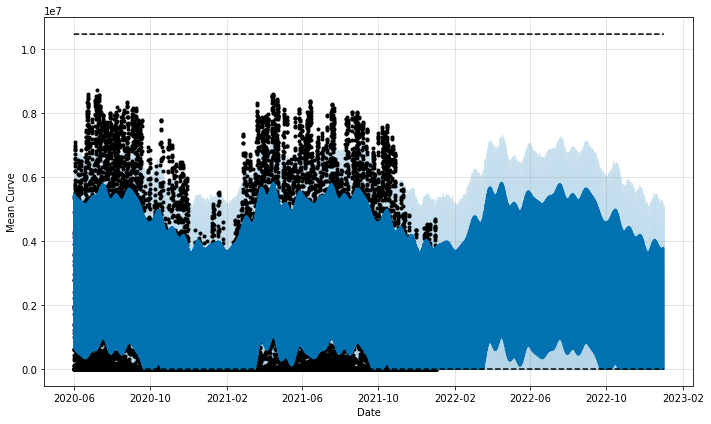

In [21]:
#visualize with Facebook internal tool
figure_1 = model.plot(forecast,
                      xlabel='Date',
                      ylabel='Mean Curve')

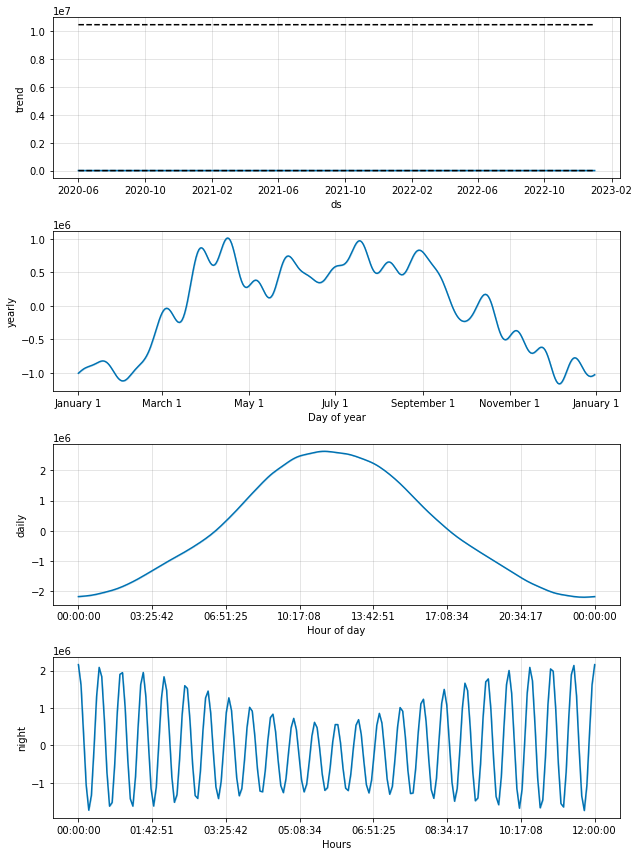

In [22]:
#visualize forecast
figure_2 = model.plot_components(forecast)

(19195.0, 19196.0)

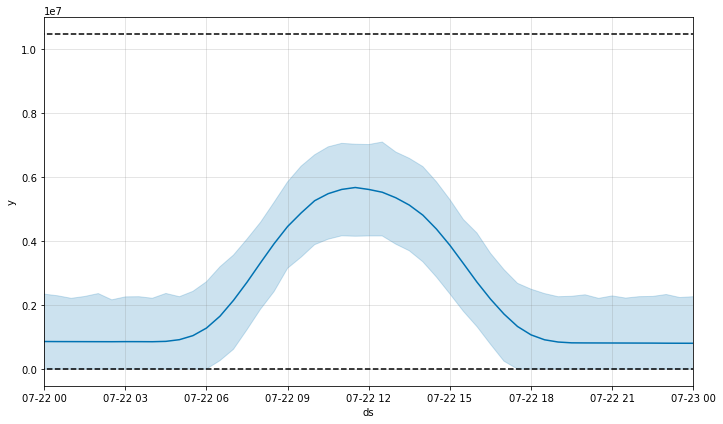

In [23]:
#Plot a specific day
fig = model.plot(forecast)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2022-07-22', '2022-07-23']))

(19348.0, 19349.0)

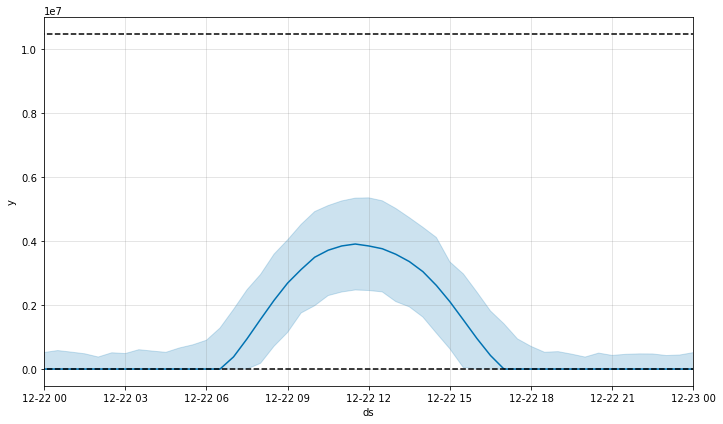

In [24]:
#Plot a specific day
fig = model.plot(forecast)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2022-12-22', '2022-12-23']))

## Format forecasted data to a database-able csv

In [25]:
fcst_df = forecast[["ds", "yhat"]]
fcst_df = fcst_df.loc[fcst_df['ds'] > MAX_DATE]
fcst_df = fcst_df.rename(columns={'ds': 'timestamp',
                                  'yhat': 'mean_curve'})

In [26]:
#area graph (Date Vs Price)
fig = px.line(fcst_df,
              x='timestamp',
              y='mean_curve')
fig.show()

In [46]:
#convert dataset into csv file
fcst_df.to_csv('prod_forecast.csv')